# IMPORTS

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle
import lightkurve as lk
from astropy.io import fits

from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants

import pymc as pm
import pymc_ext as pmx
import arviz as az

In [3]:
%matplotlib inline

In [4]:
mpl.rcParams["figure.figsize"] = (6, 4)
# mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

# Data

In [5]:
# period, t0, K, e
all_stars = {
'HD224016': [796.7, 9562.8, 95, 0.6], # ref: Guillaume. P=796.7, e=0.617, K=95.0, phi0=59562.86, ST=G5V, R=1.12 Gaia DR2, logg=4.3781 Gaia DR3
'HD17820': [2098.775, 10104.3, 67, 0.45], # ref: Guillaume. P=2098.7, e=0.45, K=67.8, phi0=60104.29, ST=G0V, R=1.18 Gaia DR2, logg=4.2828 Gaia DR3
'BD+700503': [3661.8, 10836, 88, 0.38], # ref: Guillaume. P=3661.8, e=0.38, K=88.2, phi0=60835.98, ST=K2 , R=0.85 Gaia DR2, logg=4.5172, Teff=4990.9 Gaia DR3
'TOI1273': [4.6, 8712.3, 27, 0.05], # ref: Yo. P=4.6, t0=1712.3468+7000, K=26.7, e=0.05, Rstar=1.06, logg=4.37, Teff=5690
'TOI1736': [570.0, 5283, 201, 0.36], # Martioli et al 2023. https://ui.adsabs.harvard.edu/abs/2023A%26A...680A..84M/abstract, Teff=5807, logg=4.35, R=1.15
                                # two planets, non transit: Pc=570, Kc=201, T0=2455283,  e= 0.362
                                # transit: Pb=7.07, Kb=4.1, e<0.21, T0=2458792.79
'TOI2134': [95.5, 9721.20, 9.74, 0.67], #  Rescigno et al 2023, https://ui.adsabs.harvard.edu/abs/2024MNRAS.527.5385R/abstract
                                  # two planets, transit: Pb=9.22, Kb=3.40, e=0.06, tperiastro=2459407.89
                                  # no transit: Pc=95.5, Kc=9.74, e=0.67, tperiastro=2459721.20
'TOI1710': [24.3, 9031.2, 6.4, 0.16], # Konig et al https://aanda.org/articles/aa/pdf/2022/10/aa43002-21.pdf
                             # P=24.28, K=6.4, e=0.16, T0=2459031.23
'TOI1296': [3.9, 8930.75, 34.8, 0.05], # Moutou et al https://ui.adsabs.harvard.edu/abs/2021A%26A...653A.147M/abstract P=3.94, K=34.8, e=0.05, t0=2458930.75
'TOI1298': [4.5, 8929.58, 34.4, 0.032], # Moutou et al P=4.53, K=34.4, e=0.032, t0=2458929.58
'HD88986': [146.0, 8891.7, 1.85, 0.24], # Heidari et al https://ui.adsabs.harvard.edu/abs/2024A%26A...681A..55H/abstract, possible second planet
                              # P=146.05, K=1.85, e=0.24, T0=58891.690 
'HD207897': [16.2, 8926.1, 4.24, 0.04] # Heidari et al https://ui.adsabs.harvard.edu/abs/2022A%26A...658A.176H/abstract
                             # P=16.20, K=4.24, e=0.04, t0=2458926.1
}

In [6]:
# remove the last 6 planets from dict
temp = all_stars.copy()
# for i in list(all_stars.keys())[:5]:
#     temp.pop(i)
stars = temp
stars

{'HD224016': [796.7, 9562.8, 95, 0.6],
 'HD17820': [2098.775, 10104.3, 67, 0.45],
 'BD+700503': [3661.8, 10836, 88, 0.38],
 'TOI1273': [4.6, 8712.3, 27, 0.05],
 'TOI1736': [570.0, 5283, 201, 0.36],
 'TOI2134': [95.5, 9721.2, 9.74, 0.67],
 'TOI1710': [24.3, 9031.2, 6.4, 0.16],
 'TOI1296': [3.9, 8930.75, 34.8, 0.05],
 'TOI1298': [4.5, 8929.58, 34.4, 0.032],
 'HD88986': [146.0, 8891.7, 1.85, 0.24],
 'HD207897': [16.2, 8926.1, 4.24, 0.04]}

### Master constant

In [7]:
master_old = pd.read_table('master_constant.rdb')
master_new = pd.read_table('vrconstantes_mayo24.rdb')
master_new.head()

,date,vrmoy,bissmoy
0,55783.8797,-10.8454,10.2001
1,55785.5460,-10.5431,9.9501
2,55787.0515,-10.3618,8.9001
3,55788.4402,-10.1805,7.8501
4,55789.9388,-10.3618,7.9001


<ErrorbarContainer object of 3 artists>

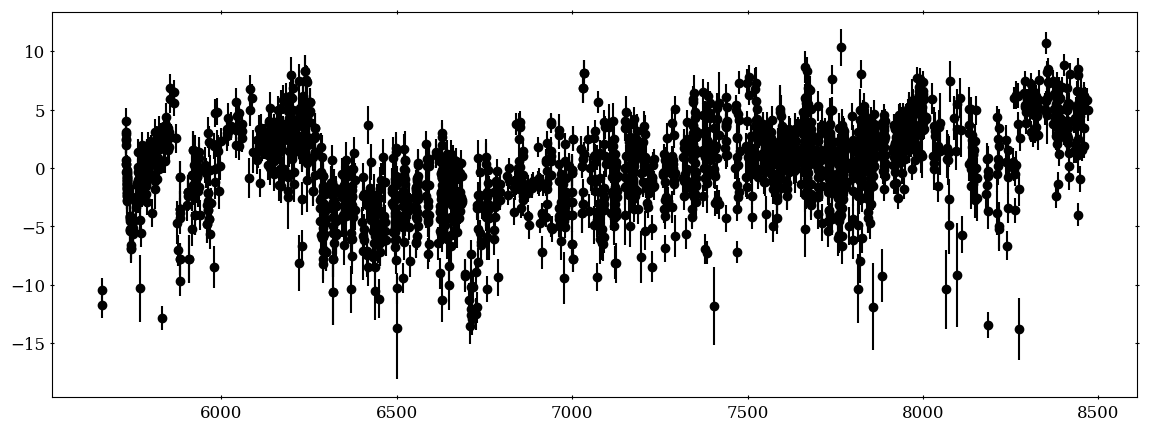

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.errorbar(master_new.jdb-50000, master_new.vrad, yerr=master_new.svrad, fmt='o', color='k', label='Data')

## Sigma Dra

In [50]:
sigmadra = pd.read_csv('HD185144OHP_tem.rdb', sep='\s+')
sigmadra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1145 entries, 0 to 1144
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   bjd       1145 non-null   float64
 1   berv      1145 non-null   float64
 2   fwhm      1145 non-null   float64
 3   contrast  1145 non-null   float64
 4   vrad0     1145 non-null   float64
 5   ccfnoise  1145 non-null   float64
 6   biss      1145 non-null   float64
 7   sn6       1145 non-null   float64
 8   sn26      1145 non-null   float64
 9   sn35      1145 non-null   float64
 10  rv_drift  1145 non-null   float64
 11  night     1145 non-null   object 
 12  filename  1145 non-null   object 
 13  cal_err   1145 non-null   float64
 14  dpr_type  1145 non-null   object 
dtypes: float64(12), object(3)
memory usage: 134.3+ KB


In [51]:
# Spotting "test days"
sigmadra.groupby('night').count().sort_values('bjd', ascending=False)[0:10]['bjd']

night
2011-06-19    24
2019-08-26    19
2011-06-14    12
2017-08-02    10
2013-07-21     8
2017-01-03     7
2012-08-29     5
2012-08-11     5
2013-08-15     4
2011-07-14     3
Name: bjd, dtype: int64

In [52]:
remove = sigmadra.groupby('night').count().sort_values('bjd', ascending=False)[0:25]['bjd'].index[0:5]

In [56]:
sigmadra = sigmadra[sigmadra['night'] != (remove[0] and remove[1] and remove[2] and remove[3] and remove[4])]

(8119.5, 9300.0)

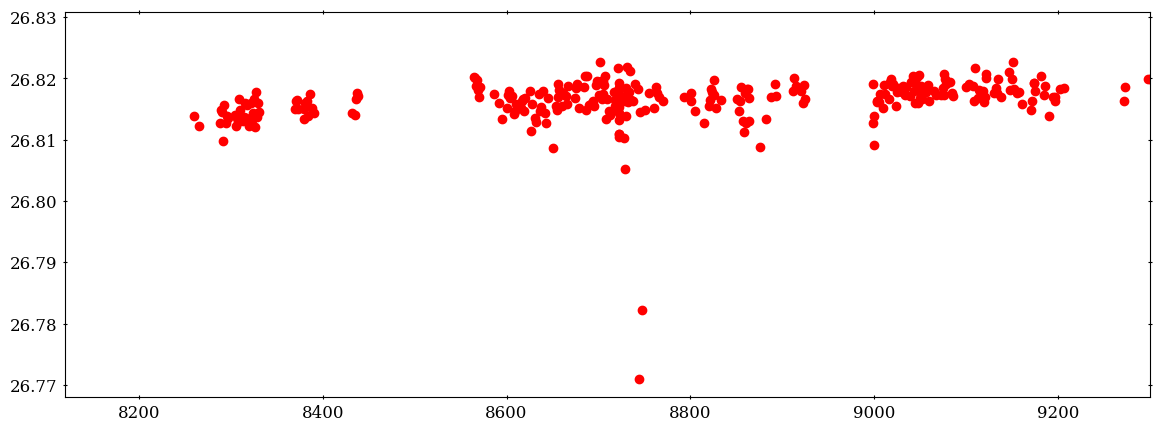

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.plot(sigmadra.bjd-50000, sigmadra.vrad0, 'o', color='r')
ax.set_xlim(8119.5, 9300)

# RV reading

In [11]:
data = {}
for i in stars:
    data["data_{0}".format(i)] = pd.read_csv('./rvs_dataset_'+i+'.csv').iloc[:, 1:] # lo último es para dropear la primera columna que estaba vacía
    print(data["data_{0}".format(i)].shape)

(26, 5)
(35, 5)
(45, 5)
(31, 5)
(30, 5)
(29, 5)
(22, 5)
(15, 5)
(18, 5)
(177, 5)
(24, 5)


In [12]:
list(data.keys())

['data_HD224016',
 'data_HD17820',
 'data_BD+700503',
 'data_TOI1273',
 'data_TOI1736',
 'data_TOI2134',
 'data_TOI1710',
 'data_TOI1296',
 'data_TOI1298',
 'data_HD88986',
 'data_HD207897']

In [13]:
# substract the systemic velocity 
for i in stars:
    data["data_"+i]['vrad'] = data["data_"+i]['vrad'].apply(lambda x: x - data["data_"+i]['vrad'].median())
    data["data_"+i]['vrad_corr_gb'] = data["data_"+i]['vrad_corr_gb'].apply(lambda x: x - data["data_"+i]['vrad_corr_gb'].median())
    data["data_"+i]['vrad_corr_mc'] = data["data_"+i]['vrad_corr_mc'].apply(lambda x: x - data["data_"+i]['vrad_corr_mc'].median())

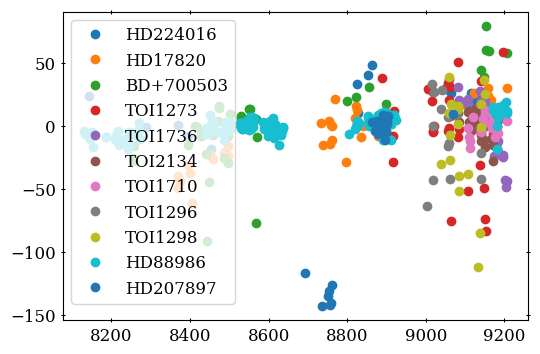

In [14]:
for i in stars:
    plt.plot(data["data_"+i]['rjd'], data["data_"+i]['vrad'], 'o', label=i)
    plt.legend(loc='best')

In [15]:
data.keys()

dict_keys(['data_HD224016', 'data_HD17820', 'data_BD+700503', 'data_TOI1273', 'data_TOI1736', 'data_TOI2134', 'data_TOI1710', 'data_TOI1296', 'data_TOI1298', 'data_HD88986', 'data_HD207897'])

# GLS

In [16]:
ls = dict()
ls2 = dict()
ls3 = dict()
frequency = dict()
frequency2 = dict()
frequency3 = dict()
power = dict()
power2 = dict()
power3 = dict()
faps = dict()
faps2 = dict()
faps3 = dict()

for key, value in data.items():
    ls[key] = LombScargle(value['rjd'], value['vrad'], value['svrad'])
    ls2[key] = LombScargle(value['rjd'], value['vrad_corr_gb'], value['svrad'])
    ls3[key] = LombScargle(value['rjd'], value['vrad_corr_mc'], value['svrad'])
    frequency[key], power[key] = ls[key].autopower(minimum_frequency=0.0002, maximum_frequency=2, samples_per_peak=15)
    frequency2[key], power2[key] = ls2[key].autopower(minimum_frequency=0.0002, maximum_frequency=2, samples_per_peak=15)
    frequency3[key], power3[key] = ls3[key].autopower(minimum_frequency=0.0002, maximum_frequency=2, samples_per_peak=15)
    probabilities = [0.01, 0.05]
    faps[key] = ls[key].false_alarm_level(probabilities)
    faps2[key] = ls2[key].false_alarm_level(probabilities)
    faps3[key] = ls3[key].false_alarm_level(probabilities)

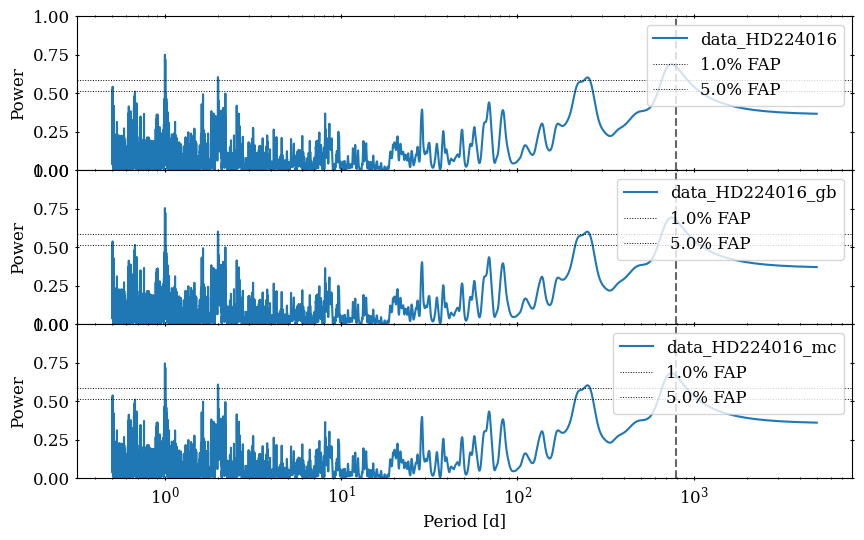

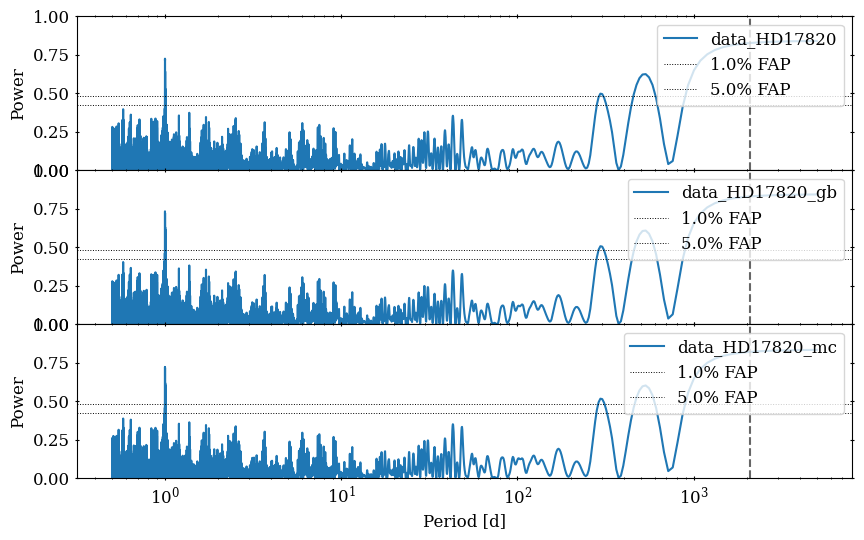

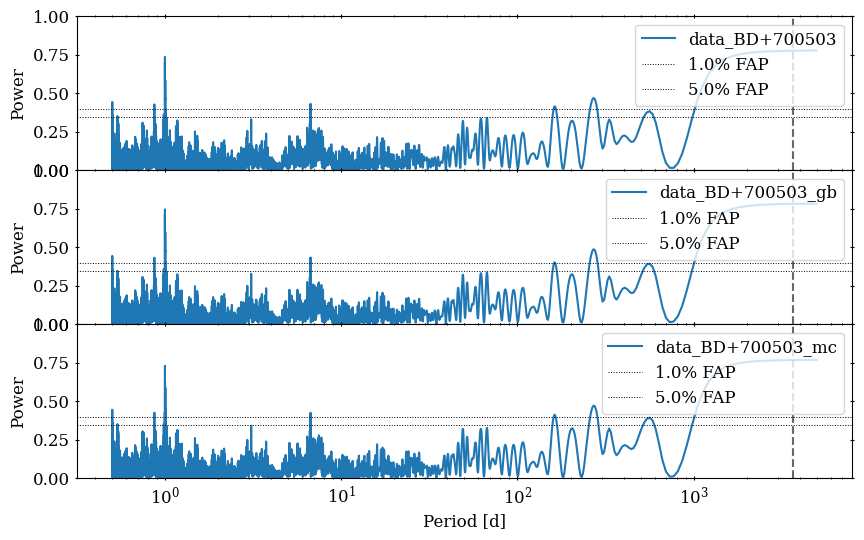

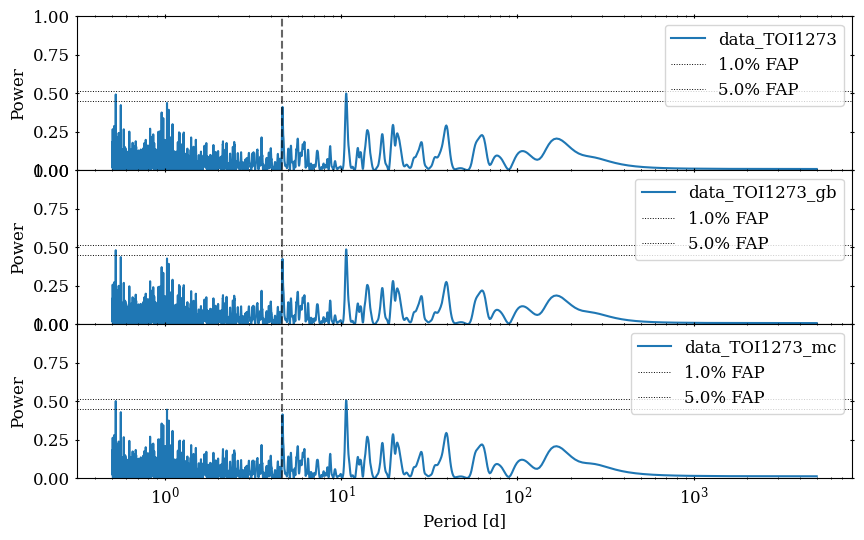

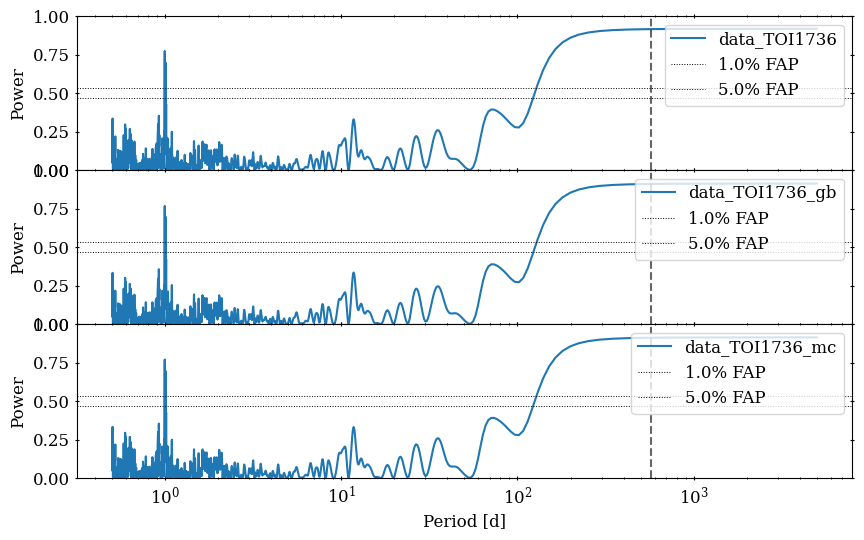

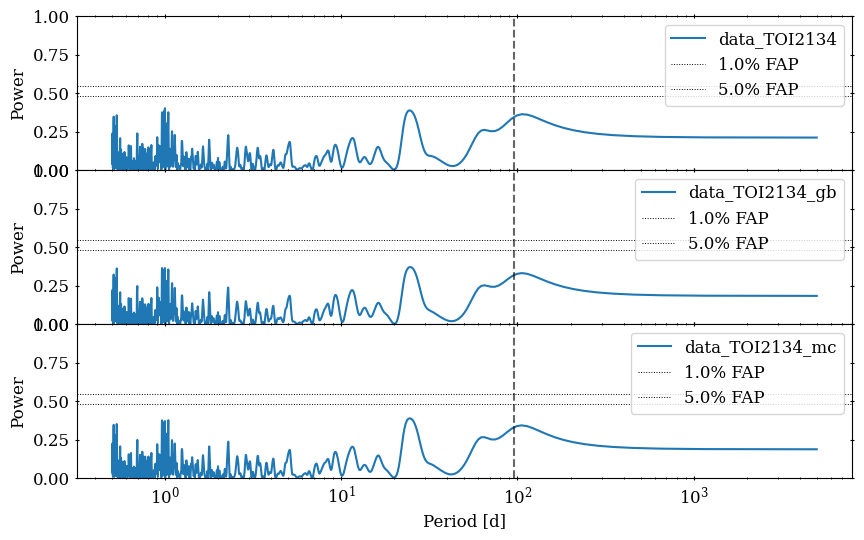

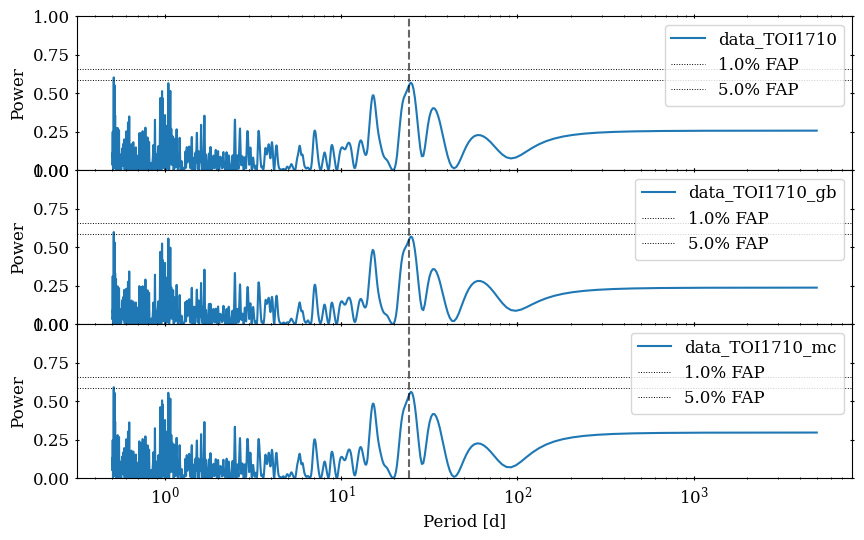

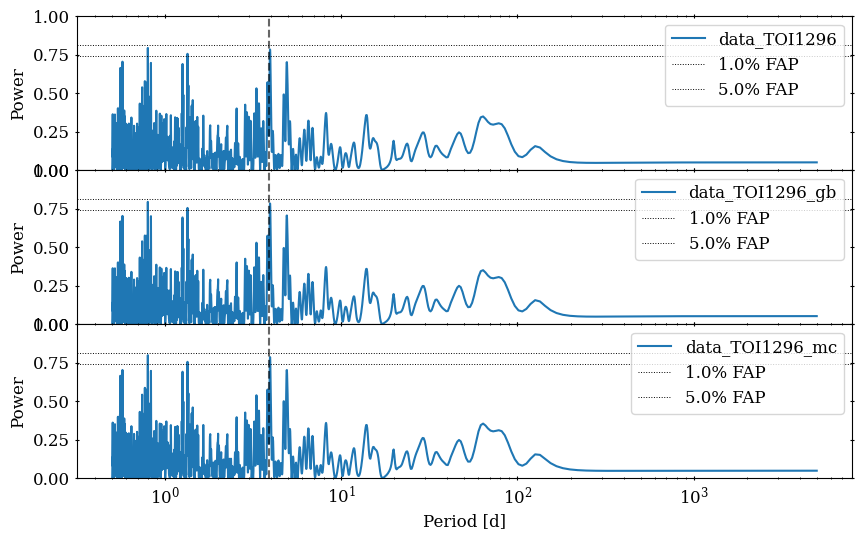

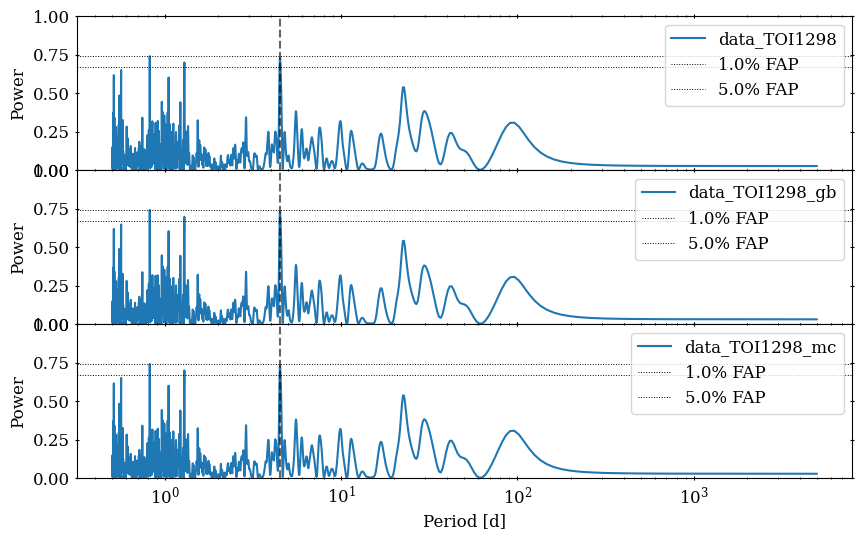

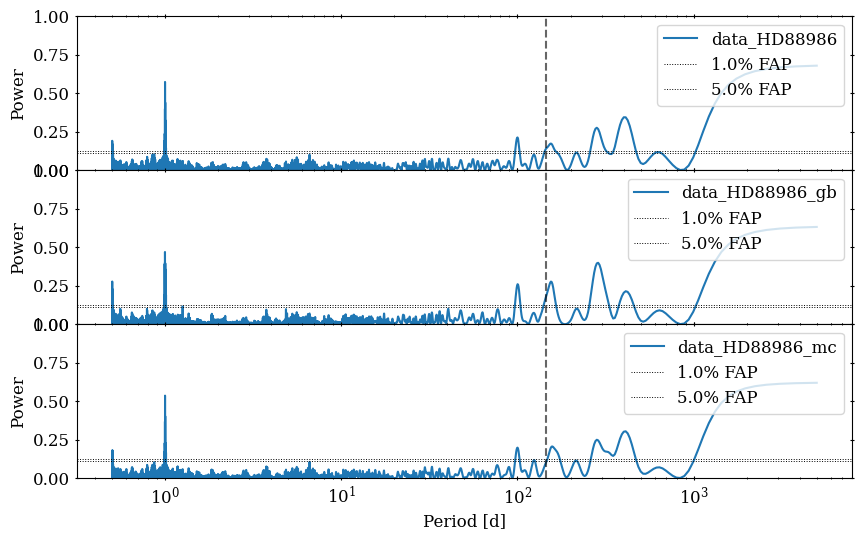

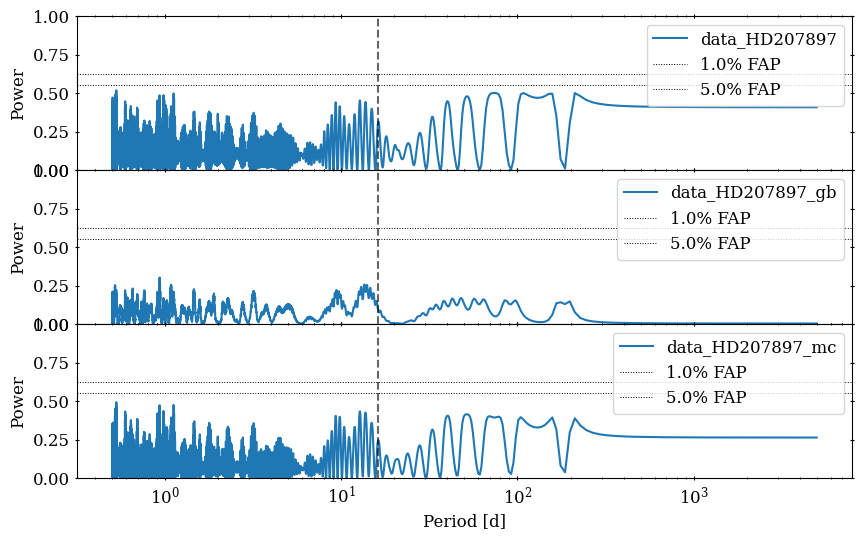

In [17]:
for i, key in enumerate(data.keys()):
    fig, axes = plt.subplots(3,1, sharex=False, figsize=(10, 6))
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    axes[0].plot(1/frequency[key], power[key], label=key)
    axes[1].plot(1/frequency2[key], power2[key], label=key+'_gb')
    axes[2].plot(1/frequency3[key], power3[key], label=key+'_mc')
    for j in range(2):
        axes[0].axhline(faps[key][j], ls=':', lw=0.7, color='black', label='{}% FAP'.format(probabilities[j]*100))
        axes[1].axhline(faps2[key][j], ls=':', lw=0.7, color='black', label='{}% FAP'.format(probabilities[j]*100))
        axes[2].axhline(faps3[key][j], ls=':', lw=0.7, color='black', label='{}% FAP'.format(probabilities[j]*100))
    for k in range(3):
        axes[k].set_xscale('log')
        #axes[k].set_xlim(0.6, 1000)
        axes[k].set_ylim(0, 1.0)
        axes[k].set_ylabel('Power')
        axes[k].set_xlabel('Period [d]')
        axes[k].legend(loc='upper right')
        axes[k].axvline(stars[key[5:]][0], ls='--', color='black', alpha=0.6, label='{} d period'.format(round(stars[key[5:]][0], 3)))

# RV fit

In [18]:
x_ref = dict()
maxrv = dict()

for key, value in data.items():
    x_ref[key] = 0.5*(value['rjd'].min() + value['rjd'].max())
    for i in range(3):
        maxrv[key+'_'+str(i)] = np.std(value['vrad'])*3

In [19]:
# Make a fine grid that spans the observation window for plotting purposes
model = dict()
t = dict()

for key, value in data.items():
    t[key] = np.linspace(value['rjd'].min() - 5, value['rjd'].max() + 5, 3000)
    for i in range(3):
        with pm.Model() as model[key+'_'+str(i)]:
            P = pm.LogNormal("P", mu=np.log(stars[key[5:]][0]), sigma=0.05)
            K = pm.LogNormal("K", mu=np.log(stars[key[5:]][2]), sigma=0.1) # upper=maxrv[k]

            logs = pm.Normal("logs", mu=np.log(np.median(value['svrad'])), sigma=1.0)
            trend = pm.Normal("trend", mu=0, sigma=10.0**-np.arange(3)[::-1], shape=3)  # [2,1,0]

            # ecs0, ecs1 = pmx.unit_disk("ecs0", "ecs1")
            # ecc = pm.Deterministic("ecc", ecs0**2+ecs1**2) # tt.sum(ecs**2)
            # omega = pm.Deterministic("omega", pm.math.arctan(ecs1/ecs0))

            ecc = pm.Uniform("ecc", lower=0, upper=0.99)
            omega = pmx.angle("omega")

            t_periastron = pm.Uniform("t0", lower=value['rjd'].min(), upper=value['rjd'].max())

            orbit = xo.orbits.KeplerianOrbit(period=P, 
                                            t_periastron=t_periastron,
                                            ecc=ecc,
                                            omega=omega)

            # And a function for computing the full RV model
            def get_rv_model(t, name=""):
                # First the RVs induced by the planet
                vrad = orbit.get_radial_velocity(t, K=K)
                pm.Deterministic("vrad" + name, vrad)

                # Define the background model
                A = np.vander(t - x_ref[key], 3) # Generate a Vandermonde matrix with t-x_ref as input vector
                bkg = pm.Deterministic("bkg" + name, pm.math.dot(A, trend))

                # Sum planet and background to get the full model
                return pm.Deterministic("rv_model" + name, vrad + bkg)

            # Define the RVs at the observed times
            rv_model = get_rv_model(value['rjd'])
            # Also define the model on a fine grid as computed above (for plotting)
            rv_model_pred = get_rv_model(t[key], name="_pred")

            # Finally add in the observation model. 
            err = pm.math.sqrt(np.asarray(value['svrad'])**2  + pm.math.exp(2 * logs))
            if i==0:
                pm.Normal("obs", mu=rv_model, sigma=err, observed=value['vrad'])
            elif i==1:
                pm.Normal("obs", mu=rv_model, sigma=err, observed=value['vrad_corr_gb'])
            elif i==2:
                pm.Normal("obs", mu=rv_model, sigma=err, observed=value['vrad_corr_mc'])

In [ ]:
# map_soln = dict()

# for key in data.keys():
#     for i in range(3):
#         with model[key+'_'+str(i)]:
#             map_soln[key+'_'+str(i)] = pm.find_MAP()
#             #map_soln = pmx.optimize(start=map_soln, vars=[logP, K, logs, t0])
#             map_soln[key+'_'+str(i)] = pm.find_MAP(start=map_soln)

# Sampling

In [ ]:
traces = dict()

for key in data.keys():
    for i in range(3):
        with model[key+'_'+str(i)]:
            traces[key+'_'+str(i)] = pm.sample(
                tune=1000,
                draws=1000,
                #start=map_soln[key+'_'+str(i)],
                cores=None,
                chains=1,
                target_accept=0.95,
                #return_inferencedata=True,
                #init="adapt_full" # adapt_full 
            )

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: 
invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 386 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 457 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: 
invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 476 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: 
invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 552 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: 
overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: overflow encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 719 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: 
invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 533 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: 
invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 640 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: 
invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: overflow encountered in square
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 729 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: 
invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1517 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: 
invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 615 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: 
invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 484 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: 
invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 416 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: 
invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1513 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: 
invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1339 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: 
invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1399 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: 
invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2954 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: 
invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1858 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, logs, trend, ecc, __omega_angle1, __omega_angle2, t0]


Output()

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: 
invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/home/jserrano/anaconda3/envs/sophieML/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:753: 
RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2773 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [20]:
for key in data.keys():
    for i in range(3):
        st = key+'_'+str(i)
        az.to_netcdf(traces[key+'_'+str(i)], f'trace.{st}.save')

NameError: name 'traces' is not defined

In [21]:
# lets join the two traces
# first load the traces 1 from saved files
alltraces = dict()
for key in all_stars.keys():
    for i in range(3):
        st = 'data_'+key+'_'+str(i)
        alltraces[st] = az.from_netcdf(f'trace.{st}.save')

In [22]:
alltraces.keys()

dict_keys(['data_HD224016_0', 'data_HD224016_1', 'data_HD224016_2', 'data_HD17820_0', 'data_HD17820_1', 'data_HD17820_2', 'data_BD+700503_0', 'data_BD+700503_1', 'data_BD+700503_2', 'data_TOI1273_0', 'data_TOI1273_1', 'data_TOI1273_2', 'data_TOI1736_0', 'data_TOI1736_1', 'data_TOI1736_2', 'data_TOI2134_0', 'data_TOI2134_1', 'data_TOI2134_2', 'data_TOI1710_0', 'data_TOI1710_1', 'data_TOI1710_2', 'data_TOI1296_0', 'data_TOI1296_1', 'data_TOI1296_2', 'data_TOI1298_0', 'data_TOI1298_1', 'data_TOI1298_2', 'data_HD88986_0', 'data_HD88986_1', 'data_HD88986_2', 'data_HD207897_0', 'data_HD207897_1', 'data_HD207897_2'])

In [23]:
summary = dict()

for key in all_stars.keys():
    for i in range(3):
        st = 'data_'+key+'_'+str(i)
        summary[st] = az.summary(alltraces[st], stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.997, round_to=6,
                    var_names=[
                        't0', 'P', 'ecc', 'omega', 'K', 'logs', 'trend'
                        ])
        print(summary[st].ess_bulk.mean(), summary[st].ess_tail.mean(), summary[st].r_hat.max())

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


655.2533961111111 642.9391833333334 nan
665.8269134444444 607.4507676666667 nan
662.5500129999999 626.0366185555556 nan
390.30284866666665 349.7233315555556 nan
435.2027664444445 353.45535722222223 nan
723.2091116666667 509.2889233333333 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


508.13529555555556 526.2529858888889 nan
104.09383166666667 187.24448977777777 nan
325.39845333333335 308.876843 nan
165.95277333333334 223.42361300000005 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


634.6590595555556 474.62730600000003 nan
574.0972957777778 465.673457 nan
763.9762466666666 565.9957426666667 nan
673.0579198888888 620.1180064444445 nan
870.7958315555557 627.9797387777778 nan
346.3106282222222 462.0675385555556 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


107.91851688888889 253.62893255555556 nan
311.73461222222227 451.9660446666667 nan
516.0018392222222 589.4190344444445 nan
385.76657266666666 468.0981806666666 nan
457.44435033333343 464.5596874444444 nan
417.65978366666667 527.9342853333333 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


362.15387244444446 389.1151756666666 nan
349.04283000000004 371.64228833333334 nan
675.3010584444445 580.6654155555556 nan
643.9171472222222 539.636947 nan
457.4074539999999 438.7863452222223 nan
326.2376347777778 383.201791 nan


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


162.28011444444445 311.9757676666667 nan
385.5723757777777 450.24809022222223 nan
81.06447244444445 151.60361833333332 nan
366.6726284444445 368.0593671111111 nan
329.3714787777778 415.33135100000004 nan


In [24]:
K = dict()
period = dict()
t_0 = dict()
eccen = dict()
rv_jitter_ = dict()
bkg_ = dict()
rv_model = dict()
rv_model_pred = dict()
rv_model_pred_ = dict()
flat_samps = dict()
dict_posteriors = dict()

for key in all_stars.keys():
    Ks = []
    #list_posteriors = []
    for i in range(3):
        index = 'data_'+key+'_'+str(i)
        K[index] = ufloat(alltraces[index].posterior["K"].median().item(), alltraces[index].posterior["K"].std().item())
        period[index] = ufloat(alltraces[index].posterior['P'].median().item(),alltraces[index].posterior['P'].std().item())
        t_0[index] = ufloat(alltraces[index].posterior['t0'].median().item(), alltraces[index].posterior['t0'].std().item())
        eccen[index] = ufloat(alltraces[index].posterior["ecc"].median().item(), alltraces[index].posterior["ecc"].std().item())
        logsigma_rv = ufloat(alltraces[index].posterior["logs"].median().item(), alltraces[index].posterior["logs"].std().item())
        rv_jitter_[index] = np.e**logsigma_rv
        flat_samps[index] = alltraces[index].posterior.stack(sample=("chain", "draw"))
        bkg_[index] = np.median(flat_samps[index]['bkg'].values, axis=-1)
        rv_model[index] = np.median(flat_samps[index]['rv_model'].values, axis=-1)

        rv_model_pred[index] = np.median(flat_samps[index]['rv_model_pred'].values, axis=-1)
        rv_model_pred_[index] = np.percentile(alltraces[index].posterior["rv_model_pred"].values,[16, 50, 84], axis=(0, 1))
        Ks.append(K[index])
        
    dict_posteriors[key] = [alltraces['data_'+key+'_'+str(i)].stack(sample=["chain","draw"]).posterior["K"].values for i in range(3)] 

    print('Sistema: ', key)
    print('K:', Ks[0], '    K_gb:', Ks[1], '    K_mc:', Ks[2])
    print('---------------------------------------------')

Sistema:  HD224016
K: 99+/-5     K_gb: 100+/-5     K_mc: 100+/-5
---------------------------------------------
Sistema:  HD17820
K: 65+/-7     K_gb: 64+/-6     K_mc: 66+/-7
---------------------------------------------
Sistema:  BD+700503
K: 86+/-9     K_gb: 87+/-8     K_mc: 86+/-8
---------------------------------------------
Sistema:  TOI1273
K: 27.4+/-2.7     K_gb: 27.3+/-2.6     K_mc: 27.2+/-2.8
---------------------------------------------
Sistema:  TOI1736
K: 115+/-8     K_gb: 199+/-19     K_mc: 154+/-15
---------------------------------------------
Sistema:  TOI2134
K: 9.9+/-1.0     K_gb: 9.8+/-0.9     K_mc: 9.9+/-1.0
---------------------------------------------
Sistema:  TOI1710
K: 6.6+/-0.6     K_gb: 6.6+/-0.6     K_mc: 6.5+/-0.6
---------------------------------------------
Sistema:  TOI1296
K: 34.4+/-3.1     K_gb: 34.7+/-3.0     K_mc: 34.2+/-2.9
---------------------------------------------
Sistema:  TOI1298
K: 36.8+/-3.5     K_gb: 36.7+/-3.4     K_mc: 37.1+/-3.5
----------

### Results

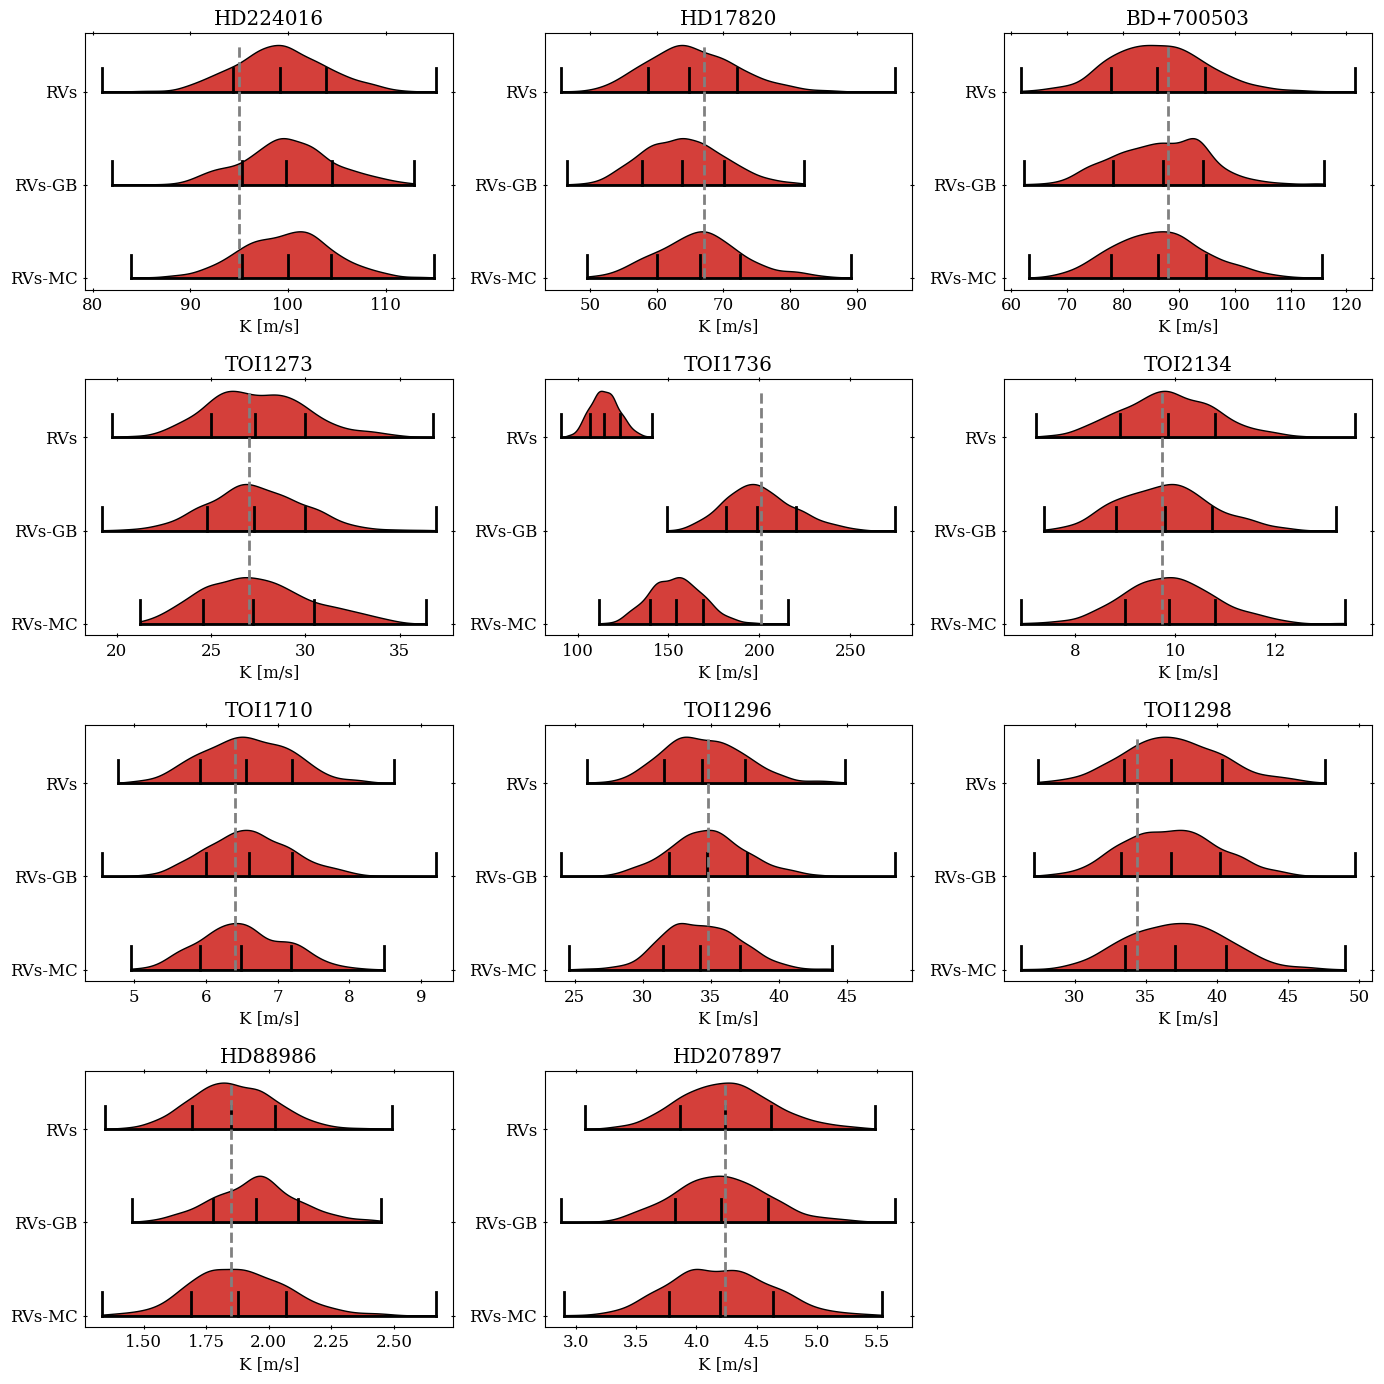

In [25]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(14, 14))
k=0
for i in range(4):
    for j in range(3):
        if i == 3 and j > 1:
            axs[i,j].set_visible(False)
            continue
        label = list(dict_posteriors.keys())[k]
        parts = axs[i,j].violinplot(dict_posteriors[label], side='high', vert=False, positions=[3,2.5,2], 
                            quantiles=[[0.16, 0.5, 0.84],[0.16, 0.5, 0.84],[0.16, 0.5, 0.84]], points=500)
        axs[i,j].vlines(all_stars[label][2], ymin=2, ymax=3.25, color='gray', linestyle='--', lw=2)
        axs[i,j].set_title(label)
        axs[i,j].set_xlabel('K [m/s]')
        axs[i,j].set_yticks([3,2.5,2], ['RVs', 'RVs-GB', 'RVs-MC'])
        for pc in parts['bodies']:
            pc.set_facecolor('#D43F3A')
            pc.set_edgecolor('black')
            pc.set_alpha(1)
        parts['cquantiles'].set_linewidth(2)
        parts['cquantiles'].set_edgecolor('black')
        parts['cmins'].set_edgecolor('black')
        parts['cmaxes'].set_edgecolor('black')
        parts['cmins'].set_linewidth(2)
        parts['cmaxes'].set_linewidth(2)
        parts['cbars'].set_linewidth(2)
        parts['cbars'].set_edgecolor('black')
        k+=1
fig.tight_layout()
fig.subplots_adjust(hspace=0.35, wspace=0.25)
# save the figure in pdf format with good resolution
fig.savefig('violinplot.pdf', dpi=300)


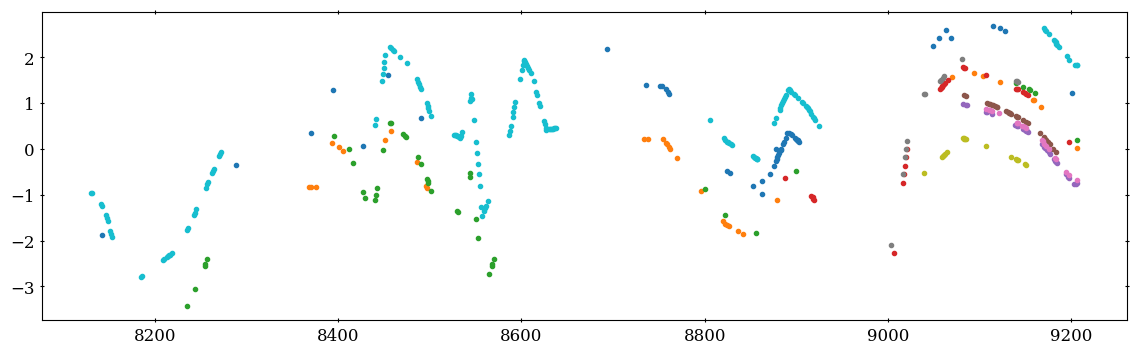

In [26]:
# Corrections
fig, ax = plt.subplots(figsize=(14, 4))
for key in data.keys():
    #ax.plot(data[key]['rjd'], data[key]['vrad'] - data[key]['vrad_corr_gb'], 'o', ms=4, zorder=10)
    ax.plot(data[key]['rjd'], data[key]['vrad'] - data[key]['vrad_corr_mc'], 'o', ms=3, zorder=50)
    #ax.legend(loc='best')